In [3]:
from PIL import Image
import numpy as np
import os
from osgeo import gdal
import cv2
import matplotlib.pyplot as plt
from natsort import natsorted

In [20]:
# Directory containing extracted files from Sentinel dataset
data_dir = './extracted/'
total = len(os.listdir(data_dir))
total

In [ ]:
# Dict used to access bands_arr
bands = {
    'B1' : 0,
    'B2' : 1,
    'B3' : 2,
    'B4' : 3,
    'B5' : 4,
    'B6' : 5,
    'B7' : 6,
    'B8' : 7,
    'B8A' : 8,
    'B9' : 9,
    'B10' : 10,
    'B11' : 11,
    'B12' : 12,
}

In [ ]:
def open_img(dir, band):
    ds = gdal.Open(dir + band)
    rb = ds.GetRasterBand(1)
    img_array = rb.ReadAsArray()
    return img_array

In [24]:
# iterate over all folders in extracted that contains band data
# and calculate histograms for individual images

hist_all = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
c = 0
for path, dir, files in os.walk(data_dir):
    if len(files) == 14:
        files = natsorted(files)[:-1]
        scene_id = path.split('/')[-2]
        print(f'{c+1}/{total}\t{scene_id}')
        print('\t Bands: ', end='')
        for i in range(13):
            print(i, end=' ')
            image = open_img(path+'/', files[i])
            hist = cv2.calcHist([image], [0], None, [2**16],[0, 2**16])
            hist_all[i].append(hist)
        print()
        c += 1

1/114	L1C_T56JML_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
2/114	L1C_T56JLN_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
3/114	L1C_T56JMN_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
4/114	L1C_T56HLK_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
5/114	L1C_T56JNN_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
6/114	L1C_T56JLL_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
7/114	L1C_T56JLM_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
8/114	L1C_T56JMP_A014070_20191116T000238
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
9/114	L1C_T56JNN_A014027_20191112T235244
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
10/114	L1C_T56JMN_A022764_20191101T000243
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
11/114	L1C_T56JMN_A022864_20191107T235247
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
12/114	L1C_T56JMN_A022907_20191111T000242
	 Bands: 0 1 2 3 4 5 6 7 8 9 10 11 12 
13/114	L1C_T56JMN_A014027_20191112T23

In [1]:
hist_all_np = {}

In [26]:
for i in range(13):
    stacked = np.stack(hist_all[i])
    hist_all_np[i] = stacked
    np.save(f'./band_hist/band_{i}.npy', stacked)

In [6]:
# Can be used to load histogram data later without opening each image again
# for i in range(13):
#     np_arr = np.load(f'./band_hist/band_{i}.npy')
#     hist_all_np[i] = np_arr

B1
954 4092


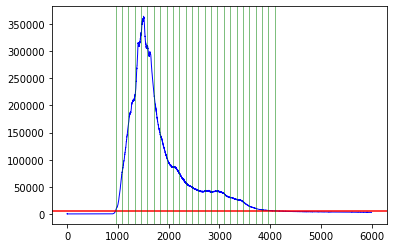

B2
699 4087


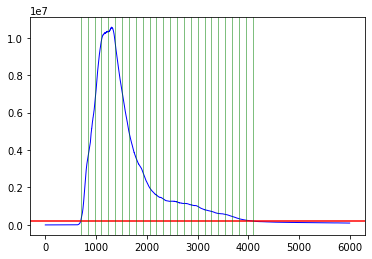

B3
473 3976


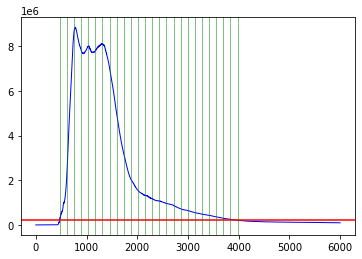

B4
268 3891


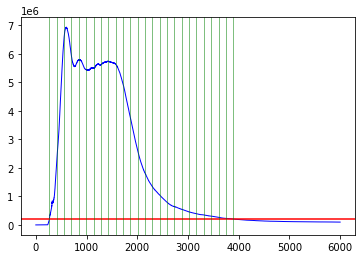

B5
231 3827


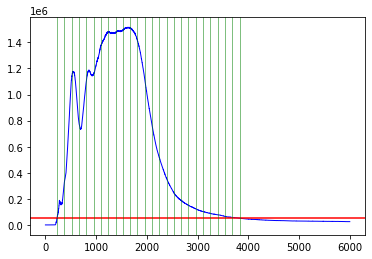

B6
202 3945


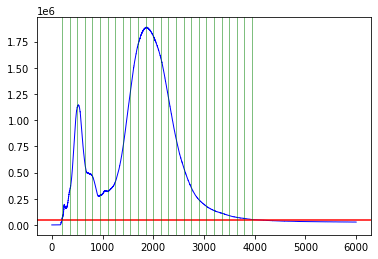

B7
180 4149


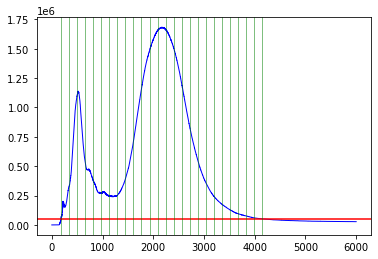

B8
152 4065


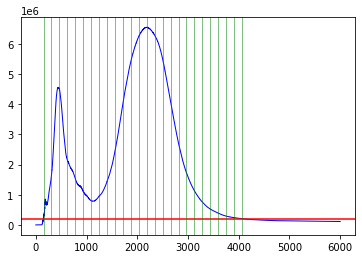

B8A
142 4383


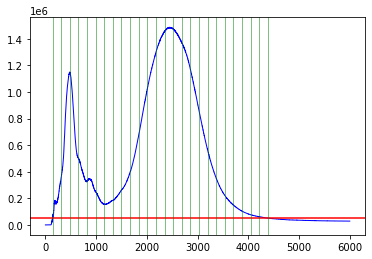

B9
60 2637


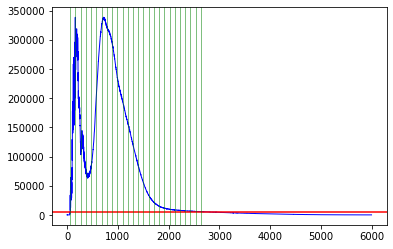

B10
6 42


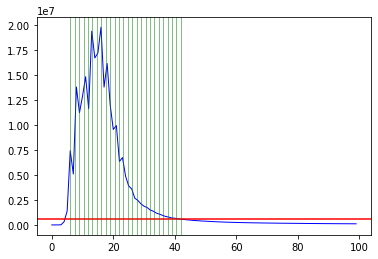

B11
51 5497


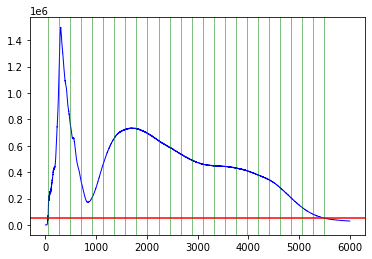

B12
34 4503


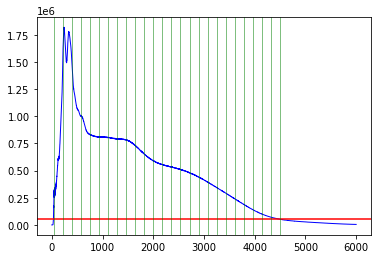

In [10]:
# Calculate thresholds and store to json file

with open('band_threshold.json', 'w') as thres_file:
    print('{', file=thres_file)

    # for each band
    for i in range(13):
        # Sum histograms of individual images
        band_hist = hist_all_np[i].sum(axis=0).reshape(2**16)
        band_hist[0] = 0

        band_name = list(bands.keys())[list(bands.values()).index(i)]
        print(band_name)

        # calculate min and max thresholds on histogram
        if i != 10:
            thres = band_hist.sum() * 0.00002
            w = np.where(band_hist > thres)[0]
            mn = w[1]
            mx = w[w.shape[0]-1]
            plt.plot(band_hist[:6000], color='b', linewidth=1)
        else:
            thres = band_hist.sum() * 0.002
            w = np.where(band_hist > thres)[0]
            mn = w[1]
            mx = w[w.shape[0]-1]
            plt.plot(band_hist[:100], color='b', linewidth=1)
        print(mn, mx)

        # plot histogram
        plt.axhline(thres, color='r')
        for x in np.linspace(mn, mx, num=26):
            plt.axvline(x, color='g', linewidth=0.5)
        plt.show()

        print(f' "{band_name}": [{mn}, {mx}]',
              file=thres_file, end=',\n' if i != 12 else '\n')
    print('}', file=thres_file)